# Nonstationary Multi-Armed Bandits

The code below generates  chapter 2 of "Reinforcement Learning: An Introduction" by Andrew Barto and Richard S. Sutton. The main issue is the Nonstationary Multi-Armed Bandits problem, whcih is addressed through epsilon-greedy, UCB and and gradient bandit algorithms: in order to do so, the 10 armed testbed is introduced.
In the 10-armed testbed environment for the Nonstationary Multi-Armed Bandits, the mean values $q(a)$ of all the arms **start out equal** and then take **independent random walks**. This means that we will have:
$$ q_0(a) = 0, \qquad \forall a \in \mathcal{A}$$

$$q_t(a) = q_{t-1}(a) + w_{t-1}, \qquad \forall a \in \mathcal{A}, \qquad \textrm{where} \quad w_t \sim \mathcal{N}(0, \sigma^2)$$

Assume $\sigma = 0.1$.

We will compare the performance of two different instances of the **Epsilon-Greedy algorithm**, one using **sample averages**, and the other using a **constant step size** $\alpha = 0.1$.
Plot the **average reward**, the **cumulative average reward**, and the **average percentage of optimal actions**: use $\epsilon=0.1$ and average over $500 \ \texttt{runs}$ for $5000 \ \texttt{steps}$.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm, trange
import seaborn as sns
from scipy.stats import poisson

In [2]:
def update_expected_action_value(expected_action_value):
        expected_action_value += np.random.normal(0, 0.01, 10) 
        return(expected_action_value)
q_estimation = np.zeros(10)
q_estimation = update_expected_action_value(q_estimation)

In [3]:
class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0.):
        
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial
        self.q_estimation = np.zeros(self.k) + self.initial # [0, 0, 0]

    
    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward # [0.5, 0.3, 0.8]
        # estimation for each action
        self.q_estimation +=  np.random.normal(0, 0.01, self.k) # [0, 0, 0]
        # # of chosen times for each action
        self.action_count = np.zeros(self.k)  #0
        
        self.best_action = np.argmax(self.q_true)   #0.8

        self.time = 0
        
        
    # get an action for this bandit
    def act(self): # action = bandit.act()
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices) 

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)  #[0 ,0 ,0 ] -> 0
        return np.random.choice(np.where(self.q_estimation == q_best)[0])
    


    # take an action, update estimation for this action
    def step(self, action): #bandit.step(action)
        # generate the reward under N(real reward, 1)
        
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time
        #mycode  mu = 0 , sigma = 0.01
        #print(self.q_true)
        self.q_true += np.random.normal(0,0.01,self.q_true.shape)
        
        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
            #H{t+1}  = H{t} + \alpha(D) (1-p)        D= difference
            #H{t+1}  = H{t} - \alpha(D) p 
            #H{t+1}  = H{t} + \alpha(D) (0-p) 
        else:
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action]) 
        return reward

def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

In [4]:
runs = 500
time = 5000
eps = 0.1
sample_average = [True, False]
bandits = [Bandit(epsilon= eps, sample_averages=sample_avg) for sample_avg in  sample_average]
best_action_counts, rewards = simulate(runs,time,bandits)

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:31<00:00,  5.47it/s]


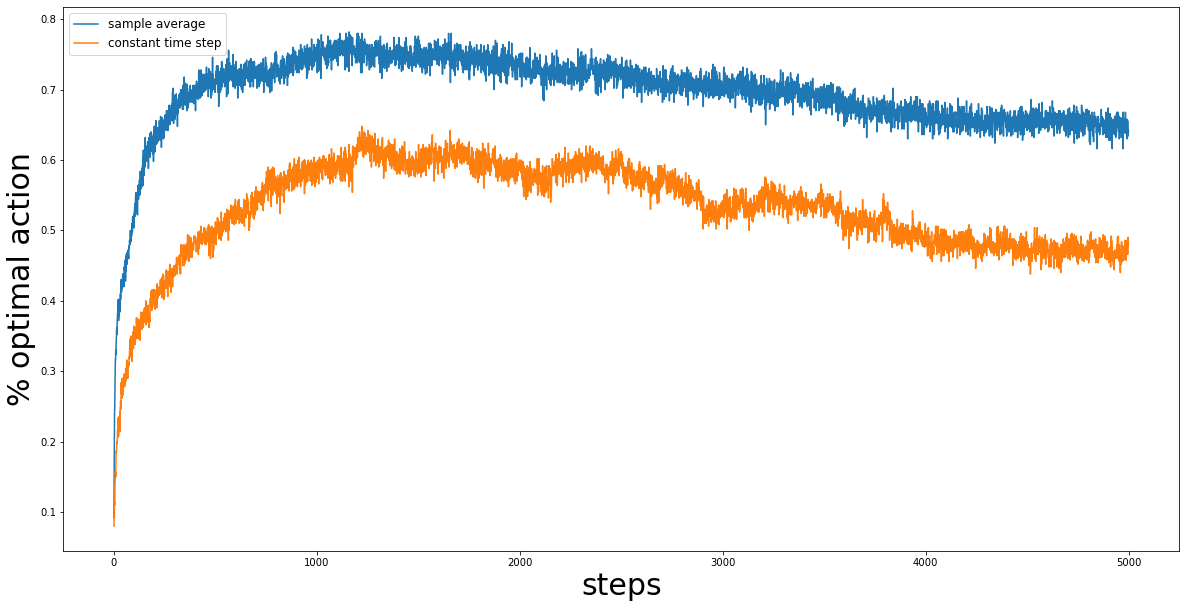

In [53]:
plt.figure(figsize=(20, 10))

plt.plot(best_action_counts[0])
plt.plot(best_action_counts[1])
plt.xlabel('steps',size = 30)
plt.ylabel('% optimal action',size = 30)
plt.legend(['sample average','constant time step'], loc = 2,prop={'size': 12})

This graph shows that $\epsilon-greedy$ with sample average, finds its optimal action more than the method with constant time step. At the begining, both methods are performing their behaviour in finding optimal action and the sample average method, increase its optimal findig faster than constant time step. However, after some time, finding optimal action decrease for both method. But, the method with constant time step, has a faster deacrease than the method with sample average. All in all, the method with sample average has a better performance in the begining and in the end of the graph for finding the optimal actions.   

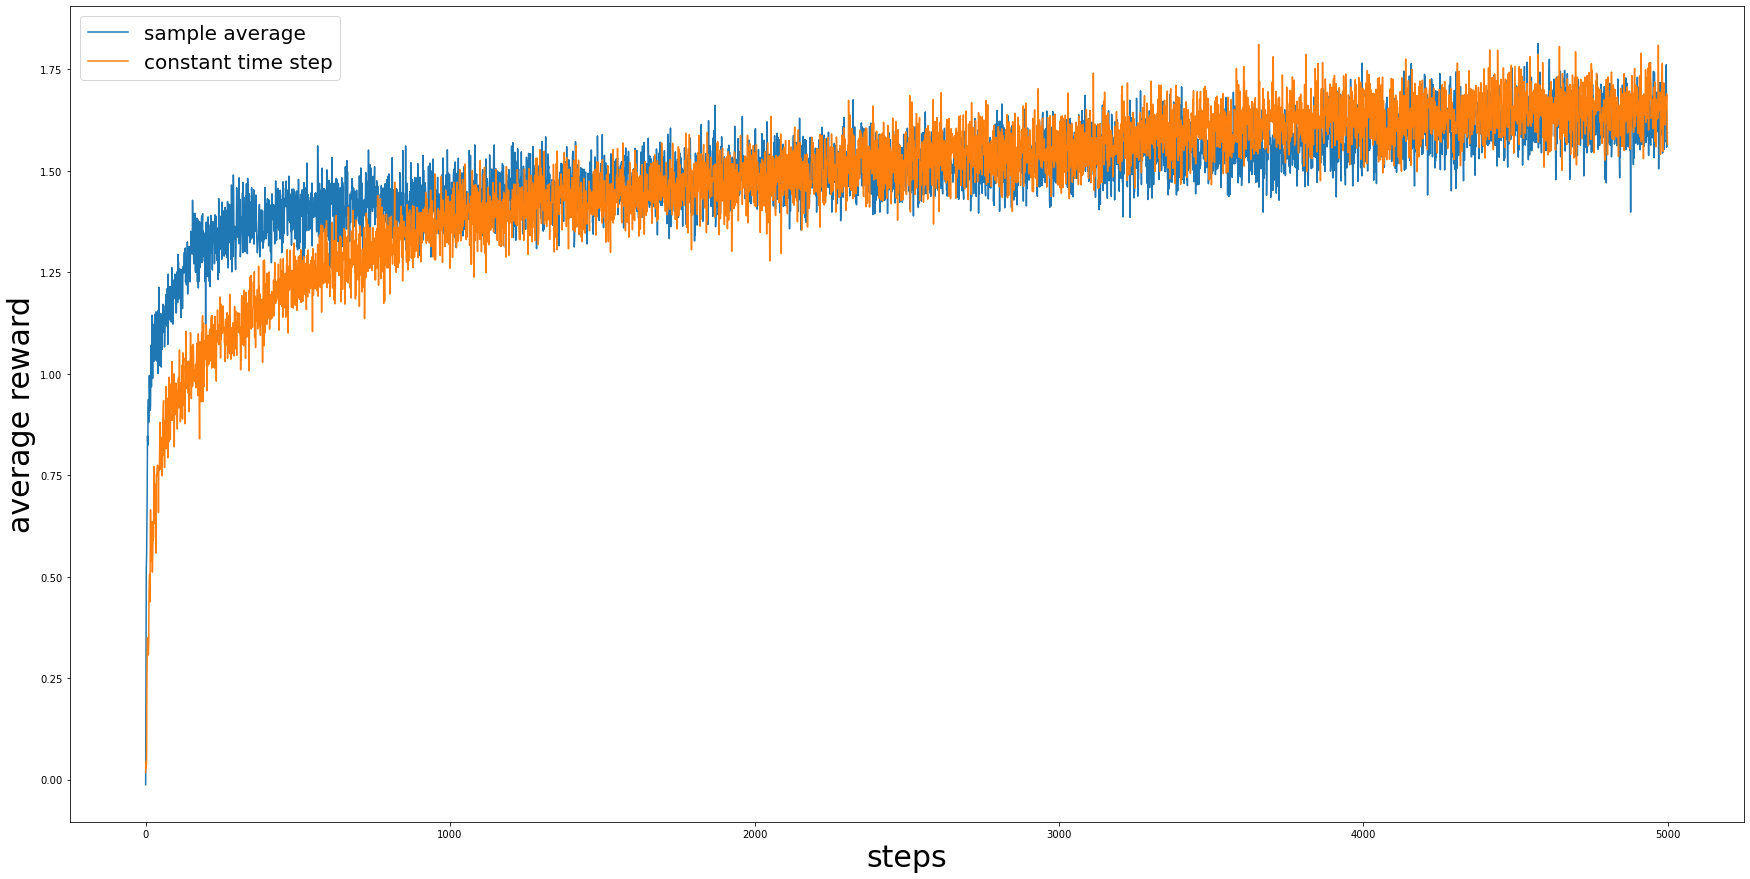

In [48]:
plt.figure(figsize=(30, 15))

plt.plot(rewards[0])
plt.plot(rewards[1])
plt.xlabel('steps',size = 30)
plt.ylabel('average reward',size = 30)
plt.legend(['sample average','constant time step'],loc = 2 ,prop={'size': 20})

This graph shows the increase in the expected rewards with experience. At the begining, $\epsilon-greedy$ method using sample averages, performs a faster convergence to its optimal which in this testbed is about 1.75. However, finally both methods reach to a similiar optimal. 

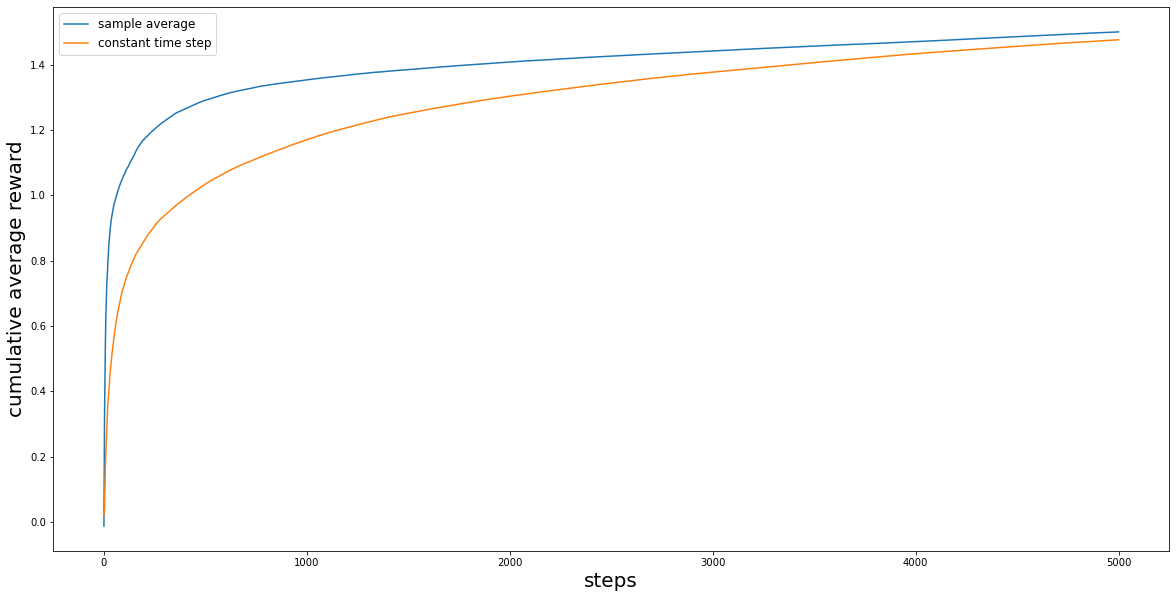

In [59]:
plt.figure(figsize=(20, 10))


data1 = np.cumsum(rewards[0,:])/(np.arange(rewards.shape[1])+1)
data2 = np.cumsum(rewards[1,:])/(np.arange(rewards.shape[1])+1)

plt.plot(data1)
plt.plot(data2)
plt.xlabel('steps',size = 20)
plt.ylabel('cumulative average reward',size = 20)
plt.legend(['sample average','constant time step'],loc = 2 ,prop={'size': 12})

We are always trying to maximize the reward and cumulative reward is a good criteria to evaluate our job. As it is obvious, cumulative reward for sample average method, increase faster than the constant time step and at the end of the graph, it is highter. With respect to our purpose which was the maximizing the reward with a faster rate, $\epsilon-greedy$ method with sample average has a better performance than $\epsilon-greedy$ with constant time step. 

Which algorithm performed best? With respsect to which metric? Why?